## Bagging
This method will use **bagging** for **positive-unlabeled** classifier learning [(Mordelet and Vert, 2014)](https://www.sciencedirect.com/science/article/pii/S0167865513002432?via%3Dihub)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Randomly choose other datapoints to also be positive, and make all others negative
3. Rinse and repeat, aggregating classification scores

In [31]:
import sys
sys.path.append('../')
from QC import *
# PU bagging method
from PU_bagging import *
sc.settings.set_figure_params(dpi=80)

In [2]:
# pipeline functions
from qc_pipeline import *

In [ ]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

Read in normal human colon sample

In [3]:
s1 = sc.read_h5ad('../data/2771-AS-2-CTTGTA_S2.h5ad')
# see how many "good cells" Ken labeled (1)
s1.obs['ken_filter'].value_counts()

0    3721
1    1536
Name: ken_filter, dtype: int64

In [4]:
%%time
# preprocess data with fcc recipe
sc.pp.filter_genes(s1, min_cells=1)
recipe_fcc(s1, X_final='arcsinh_norm', mito_names='^mt-')

CPU times: user 11.4 s, sys: 2.07 s, total: 13.5 s
Wall time: 13.5 s


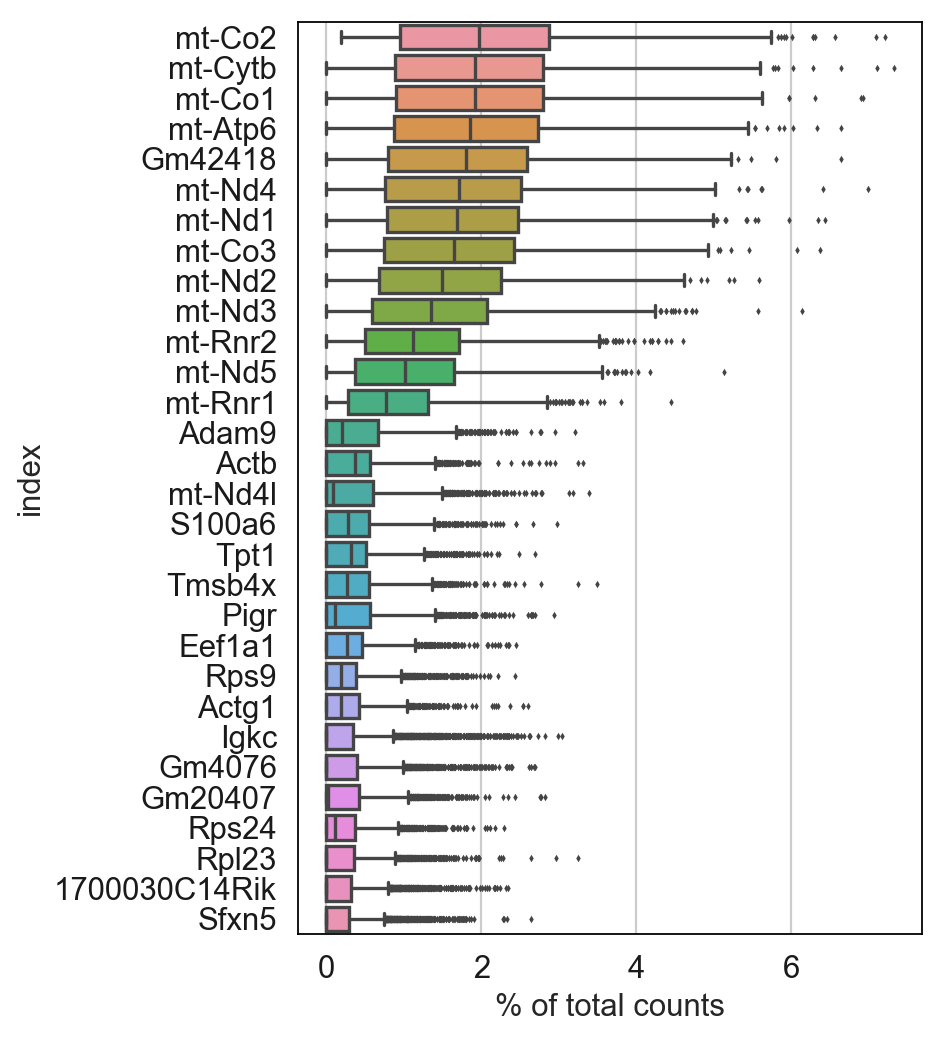

In [5]:
# pct counts in top 50 genes might be useful, as top genes are typically ambient (in empty drops at high frequency)
sc.pl.highest_expr_genes(s1, n_top=30)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [6]:
s1_thresh = auto_thresh_obs(s1, method='otsu')

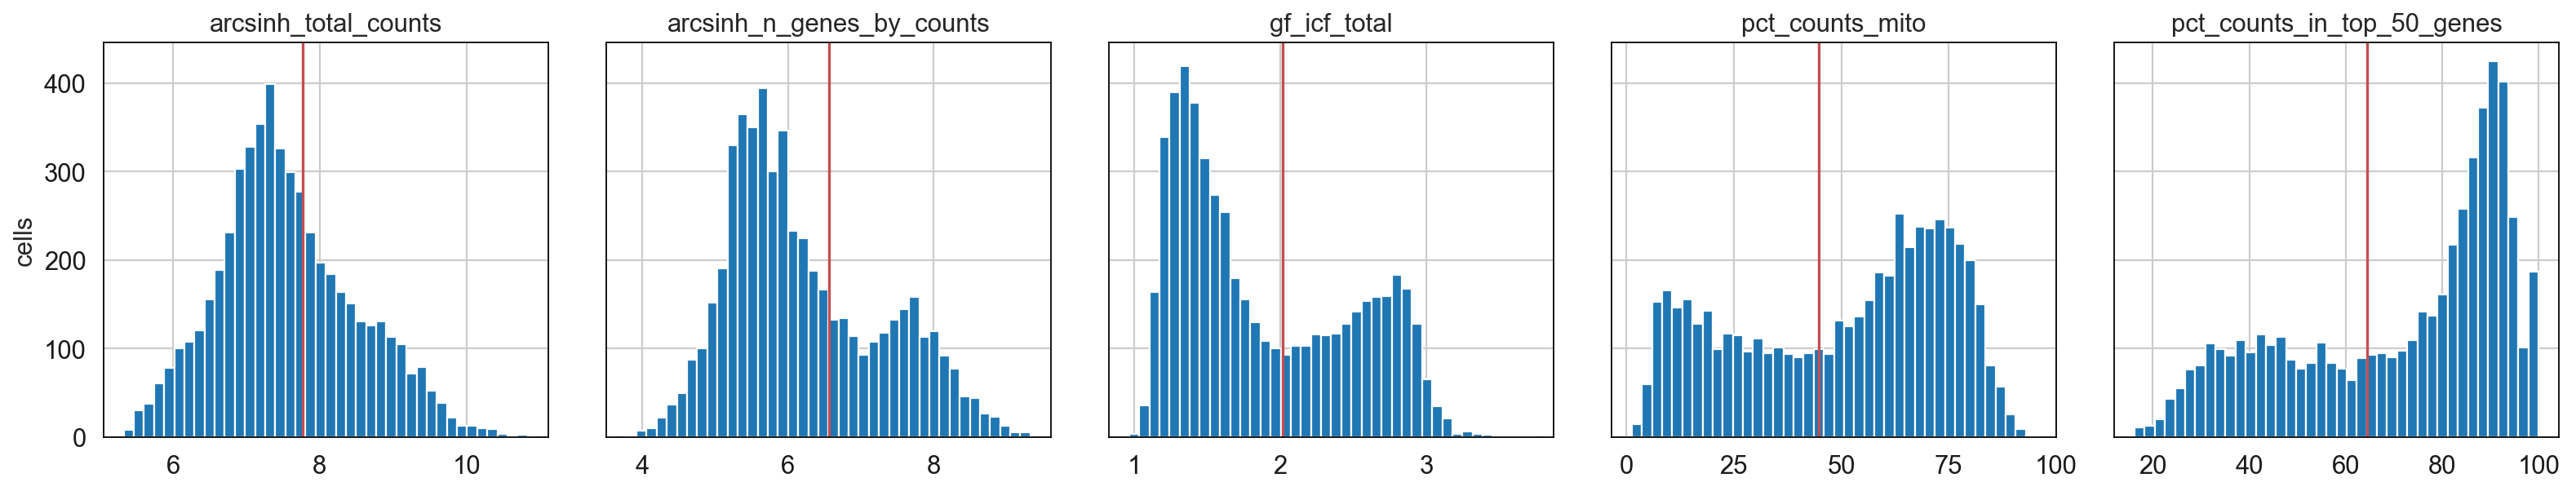

In [7]:
plot_thresh_obs(s1, s1_thresh)

### a couple different ways of visualizing these thresholds vs Ken's filter...

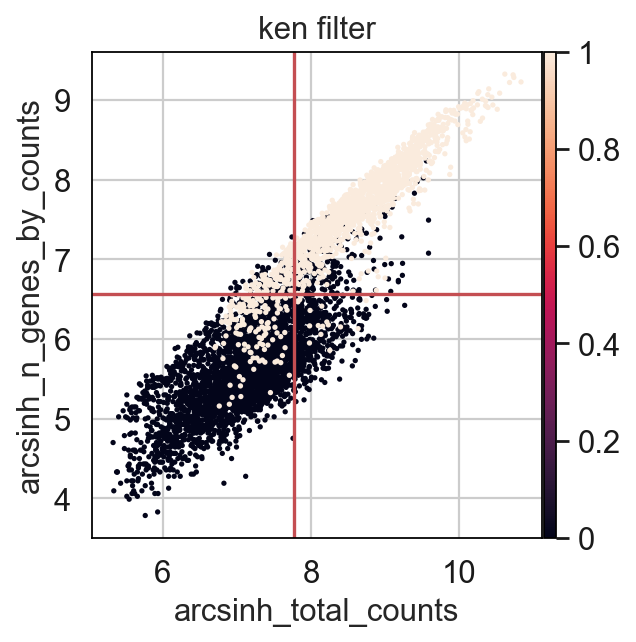

In [8]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='arcsinh_total_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_total_counts'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

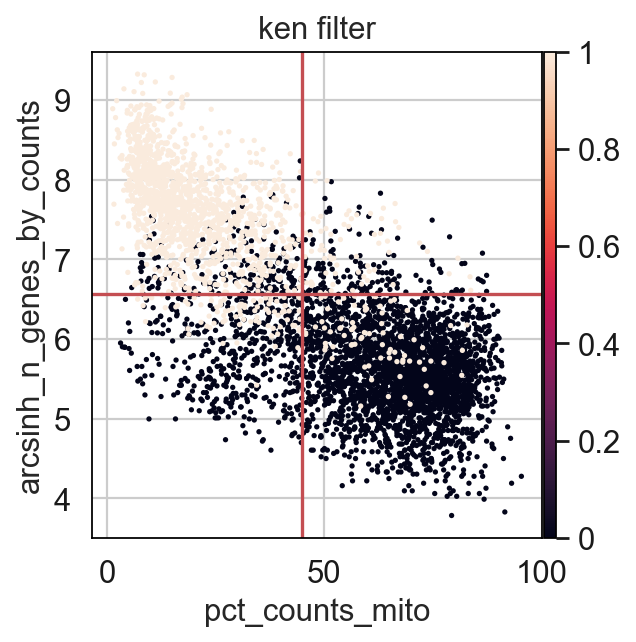

In [9]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='ken_filter', show=False)
ax.axvline(s1_thresh['pct_counts_mito'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

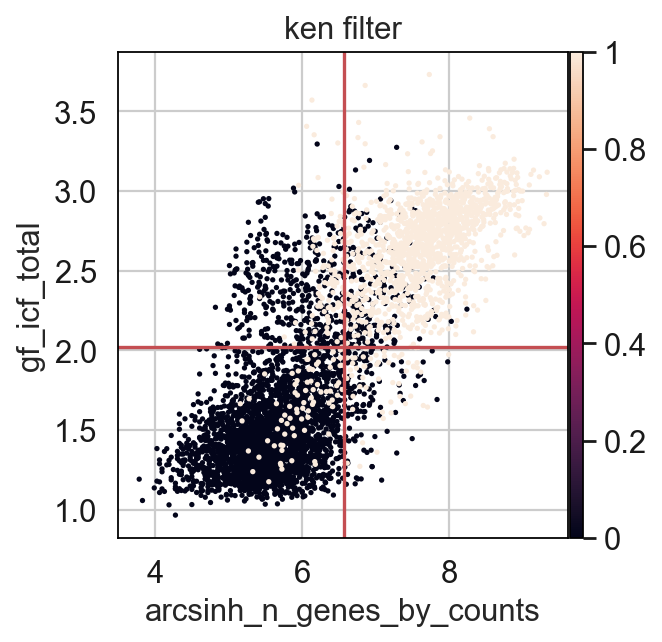

In [10]:
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

---
### Use combination of the above 5 filters to "hard threshold" our dataset and compare to Ken's labels

In [11]:
s1.obs['thresh_filter'] = 0
s1.obs.loc[
    (s1.obs['arcsinh_n_genes_by_counts'] >= s1_thresh['arcsinh_n_genes_by_counts']) & 
    (s1.obs['gf_icf_total'] >= s1_thresh['gf_icf_total']) & 
    (s1.obs['arcsinh_total_counts'] >= s1_thresh['arcsinh_total_counts']) & 
    (s1.obs['pct_counts_mito'] <= s1_thresh['pct_counts_mito']) & 
    (s1.obs['pct_counts_in_top_50_genes'] <= s1_thresh['pct_counts_in_top_50_genes']), 
    'thresh_filter'
] = 1

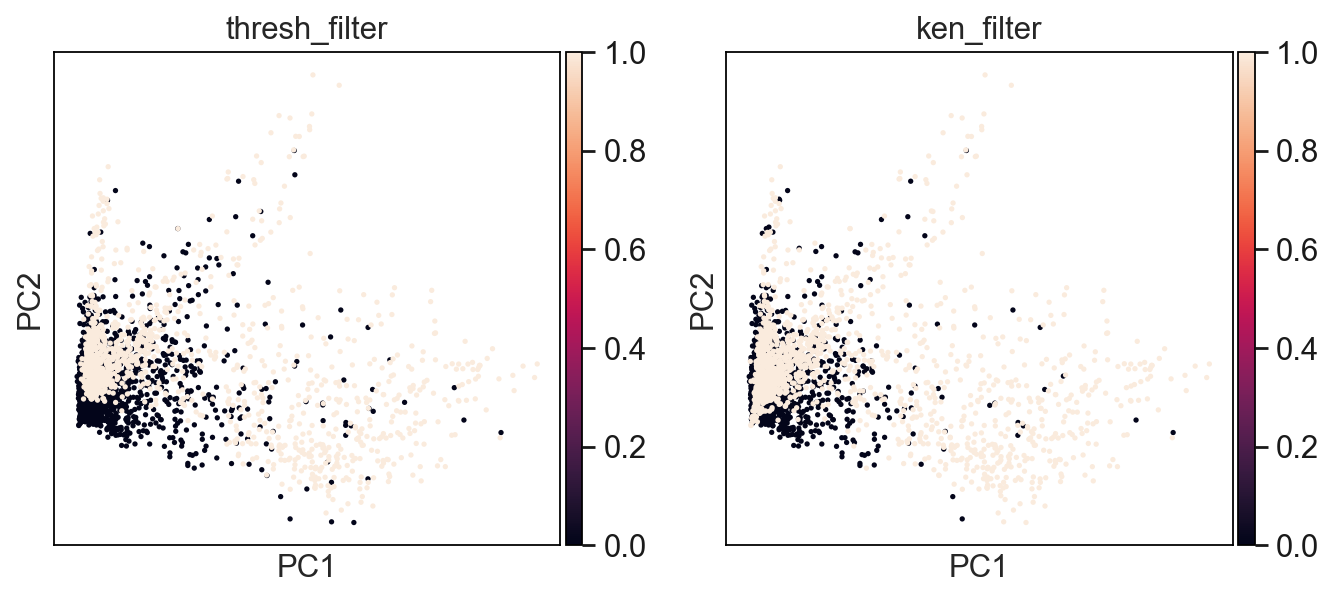

CPU times: user 2.44 s, sys: 985 ms, total: 3.43 s
Wall time: 886 ms


In [12]:
%%time
# perform 10-component PCA (for training our classifiers later) and look at the two filter labels side-by-side
sc.tl.pca(s1, n_comps=10)
sc.pl.pca(s1, color=['thresh_filter','ken_filter'])

#### Look at set differences with `ken_filter`:

In [13]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

82

In [14]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['thresh_filter']==1])))

356

In [15]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]) ^ set(s1.obs_names[s1.obs['ken_filter']==1]))

438

---
#### ~400 cell difference isn't bad with hard thresholding. Let's train a two-step PU classifier to reconfigure these labels.
#### First, pick reliable positives, or "bad" cells based on the above thresholds.
#### Below defines probabilities for random sampling these training cells

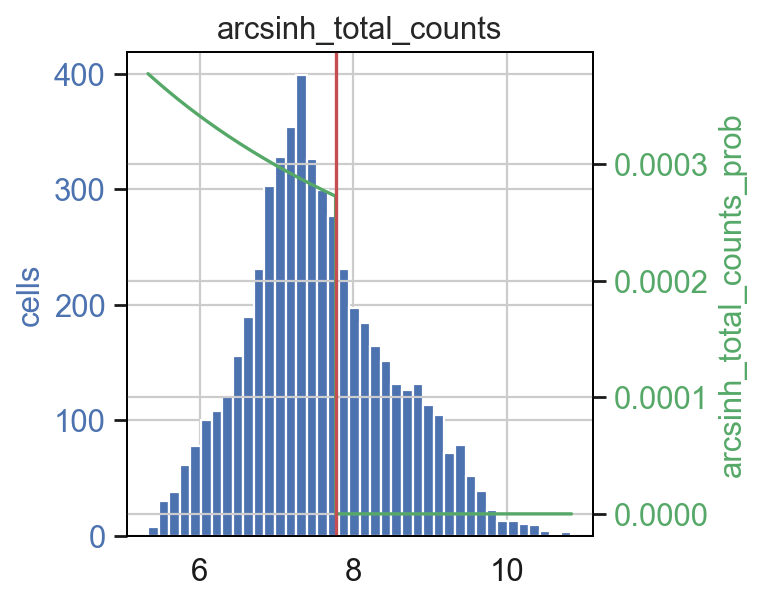

In [16]:
sampling_probabilities(s1, 'arcsinh_total_counts', s1_thresh['arcsinh_total_counts'], direction='below')

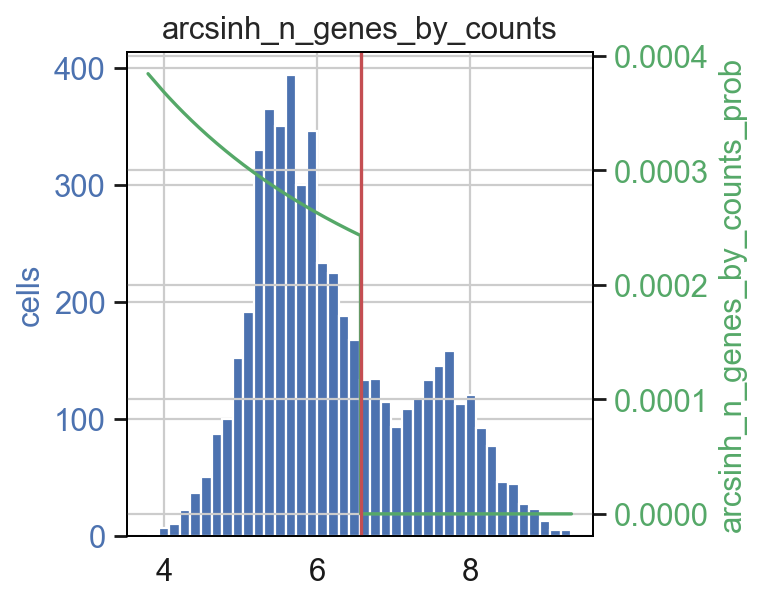

In [17]:
sampling_probabilities(s1, 'arcsinh_n_genes_by_counts', s1_thresh['arcsinh_n_genes_by_counts'], direction='below')

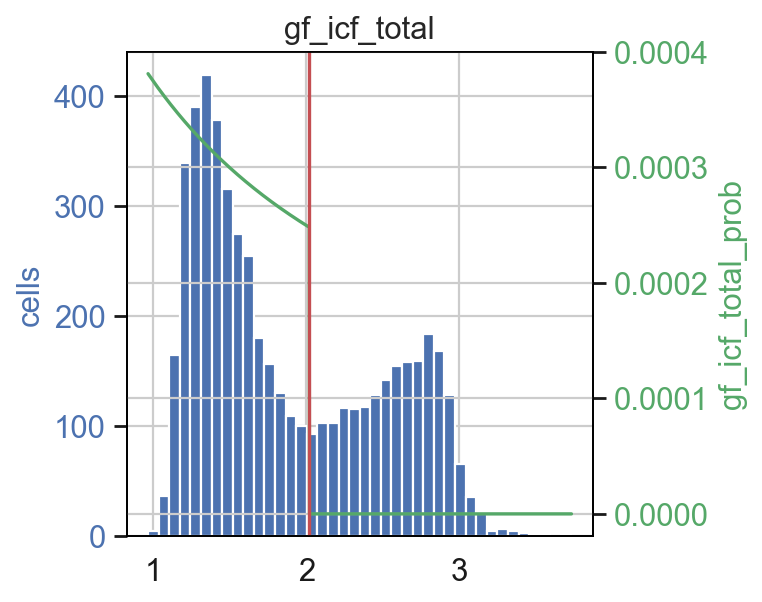

In [18]:
sampling_probabilities(s1, 'gf_icf_total', s1_thresh['gf_icf_total'], direction='below')

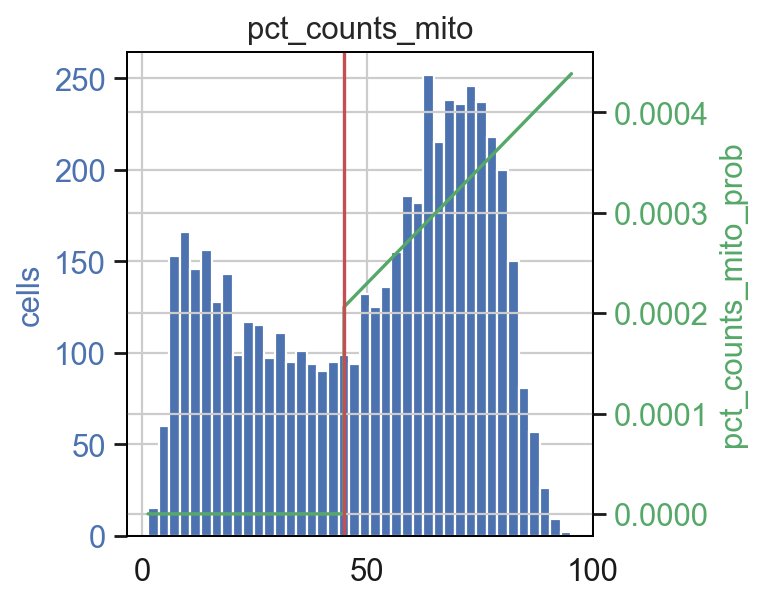

In [19]:
sampling_probabilities(s1, 'pct_counts_mito', s1_thresh['pct_counts_mito'], direction='above')

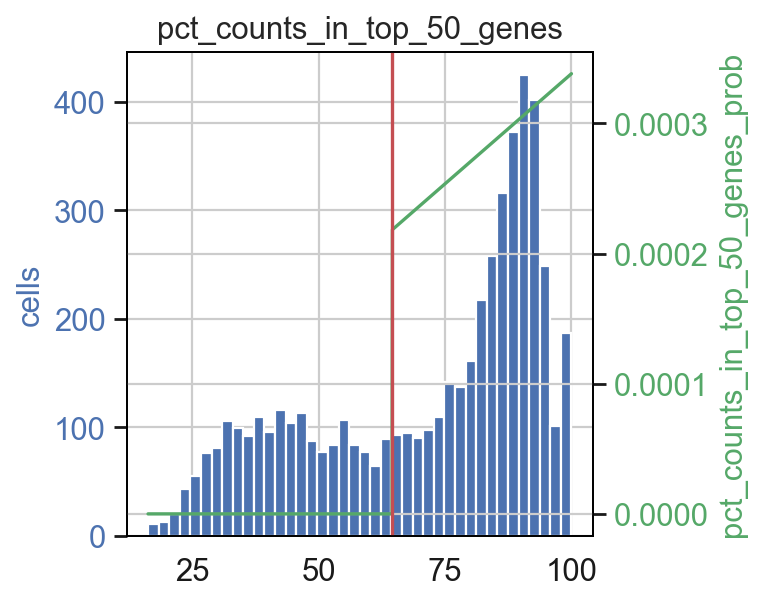

In [20]:
sampling_probabilities(s1, 'pct_counts_in_top_50_genes', s1_thresh['pct_counts_in_top_50_genes'], direction='above')

#### combine probabilities for training set (bad/empty cells):

In [21]:
# combine and normalize probabilities
s1.obs['train_prob'] = s1.obs['arcsinh_n_genes_by_counts_prob'] + s1.obs['gf_icf_total_prob'] + s1.obs['arcsinh_total_counts_prob'] + s1.obs['pct_counts_in_top_50_genes_prob'] + s1.obs['pct_counts_mito_prob']

s1.obs['train_prob'] /= s1.obs['train_prob'].sum()

#### A couple ways of visualizing these probabilities

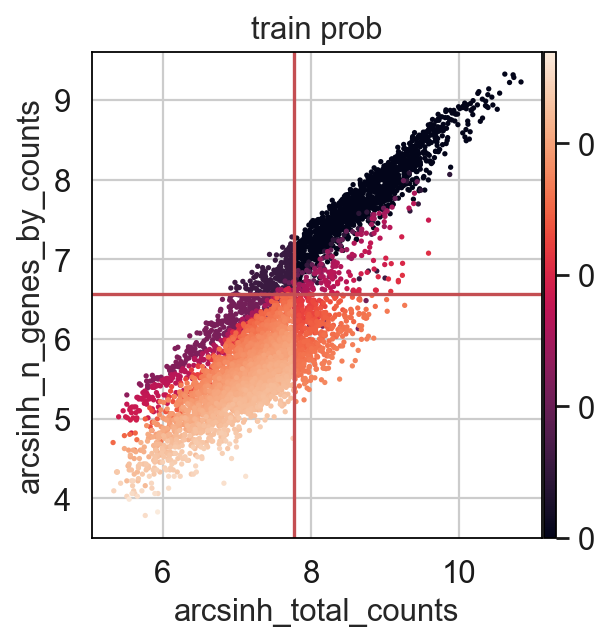

In [22]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='arcsinh_total_counts', color='train_prob', show=False)
ax.axvline(s1_thresh['arcsinh_total_counts'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

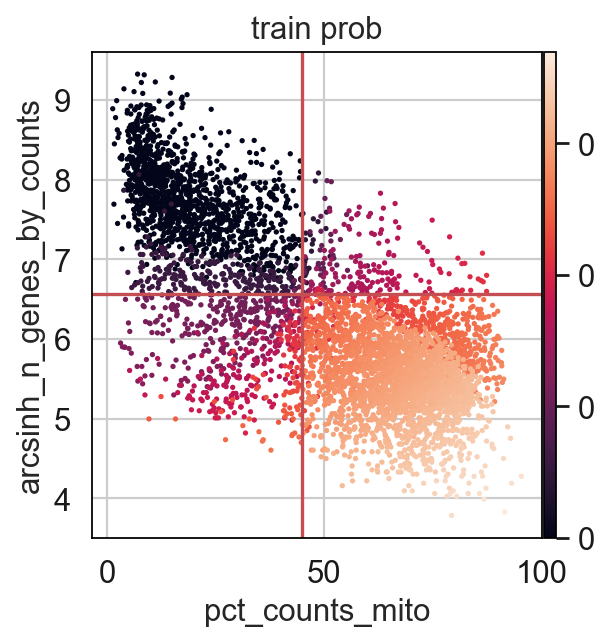

In [23]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='train_prob', show=False)
ax.axvline(s1_thresh['pct_counts_mito'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

---
#### Randomly sample training set (reliable "positives" or dead/empty cells)

In [24]:
generate_training_labels(
    s1,
    pos_prob=s1.obs['train_prob'],
    pos_size=int(0.70*(s1.n_obs - s1.obs['thresh_filter'].sum())),
    neg_prob=None,
    neg_size=None,
    name='train',
    seed=18
)

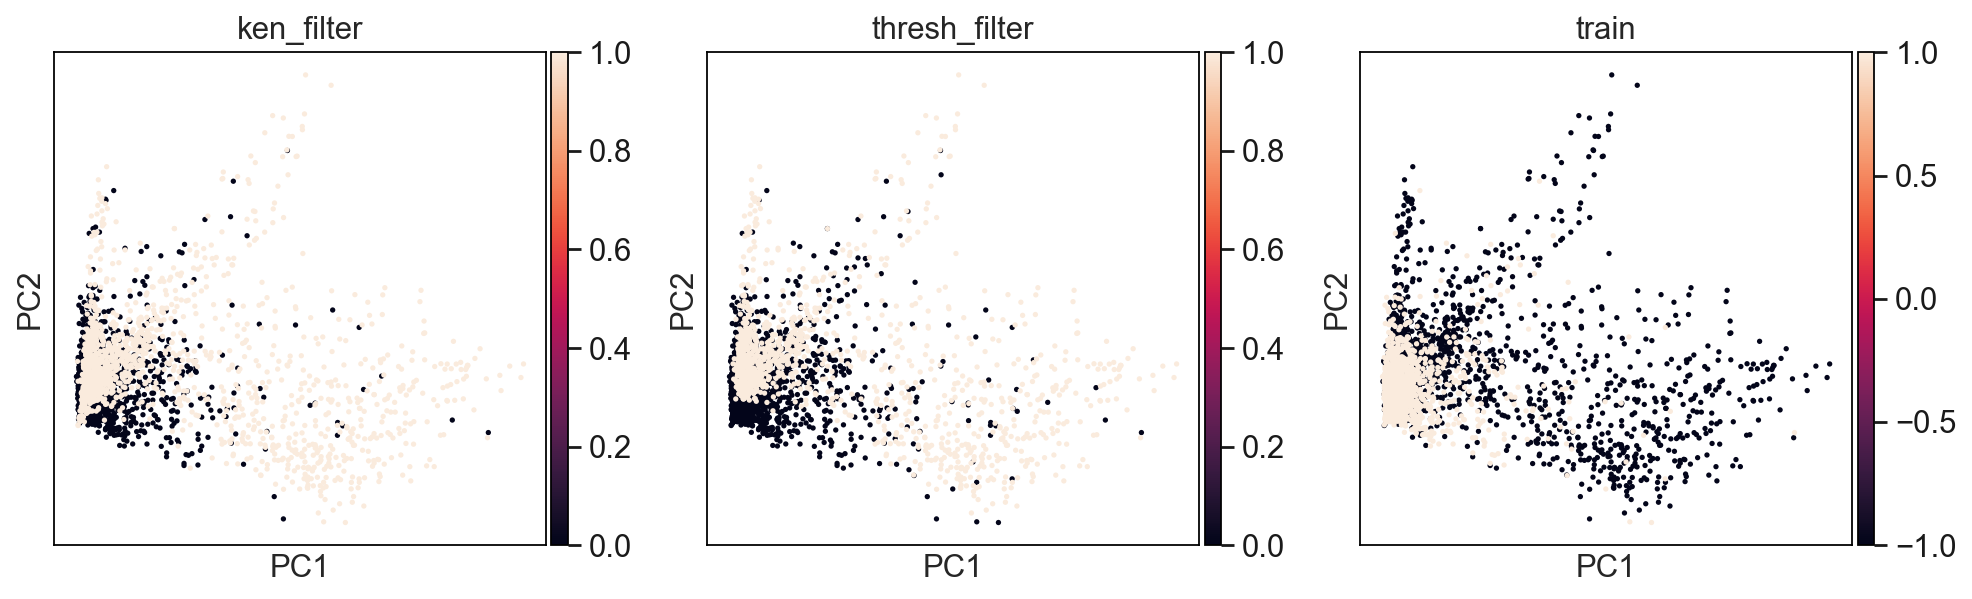

In [25]:
# -1: unlabeled
# 1: positive (dead/empty)
# 0: negative (live)

sc.pl.pca(s1, color=['ken_filter','thresh_filter','train'])

Compare our training set to Ken's filter.  
We want a small number here, but <= 50 is acceptable, since our machine learning classifier will work out the kinks...

In [26]:
len(set(s1.obs.loc[s1.obs['train']==1].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==0].index)))

172

In [27]:
len(set(s1.obs.loc[s1.obs['train']==0].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==1].index)))

0

In [28]:
s1.obs['train'].value_counts()

 1    2796
-1    2461
Name: train, dtype: int64

---
#### get training set and labels for two-step learning method:

In [29]:

# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['train'].copy(deep=True) # training labels are from .obs df

In [32]:
%%time
bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

s1.obs['bagging_score'] = bc.oob_decision_function_[:,1]

CPU times: user 2.78 s, sys: 156 ms, total: 2.93 s
Wall time: 9.9 s


#### predict the remaining unlabeled cells using the trained (and re-trained) RandomForestClassifier():

In [35]:
s1.obs['bagging_label'] = bc.predict(X) 

/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


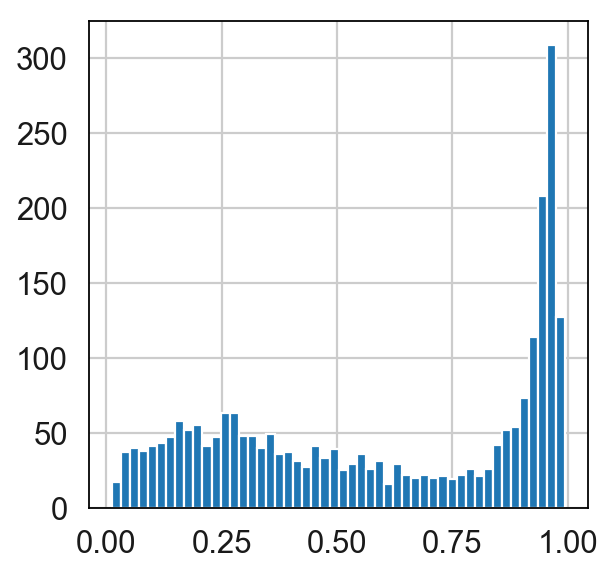

In [33]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(s1.obs['bagging_score'], bins=50)

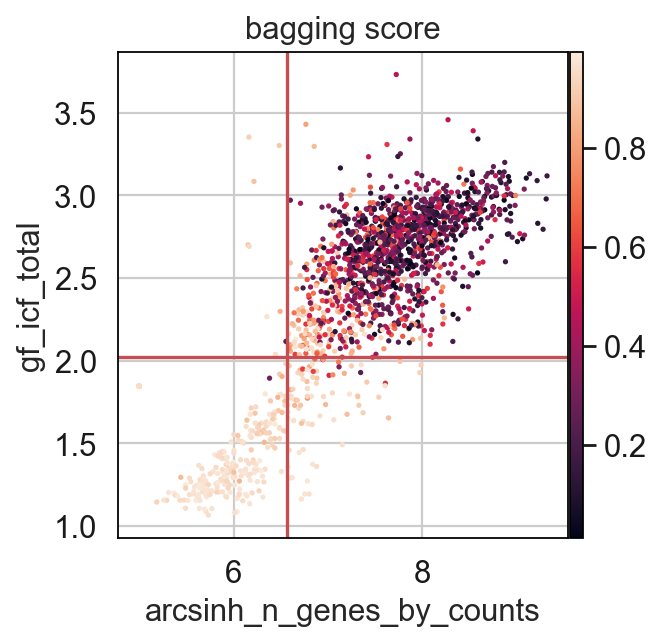

In [34]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='bagging_score', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

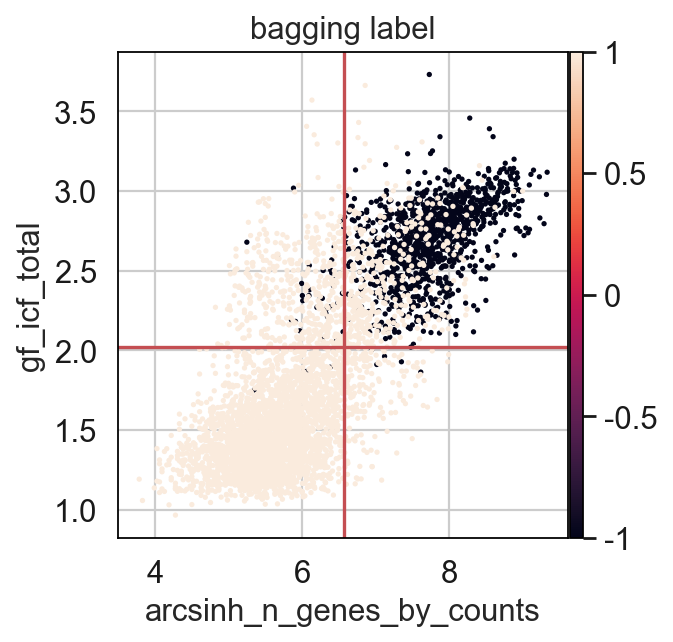

In [41]:
# look at our final labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='bagging_label', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

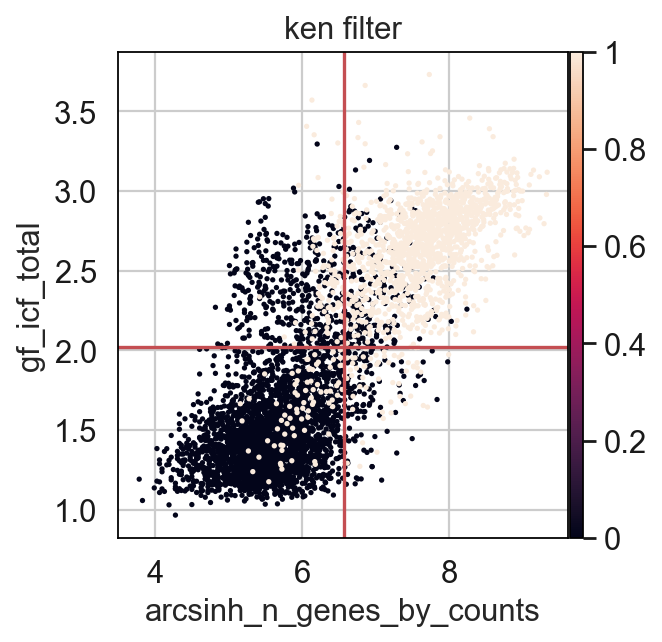

In [40]:
# compare to Ken's labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

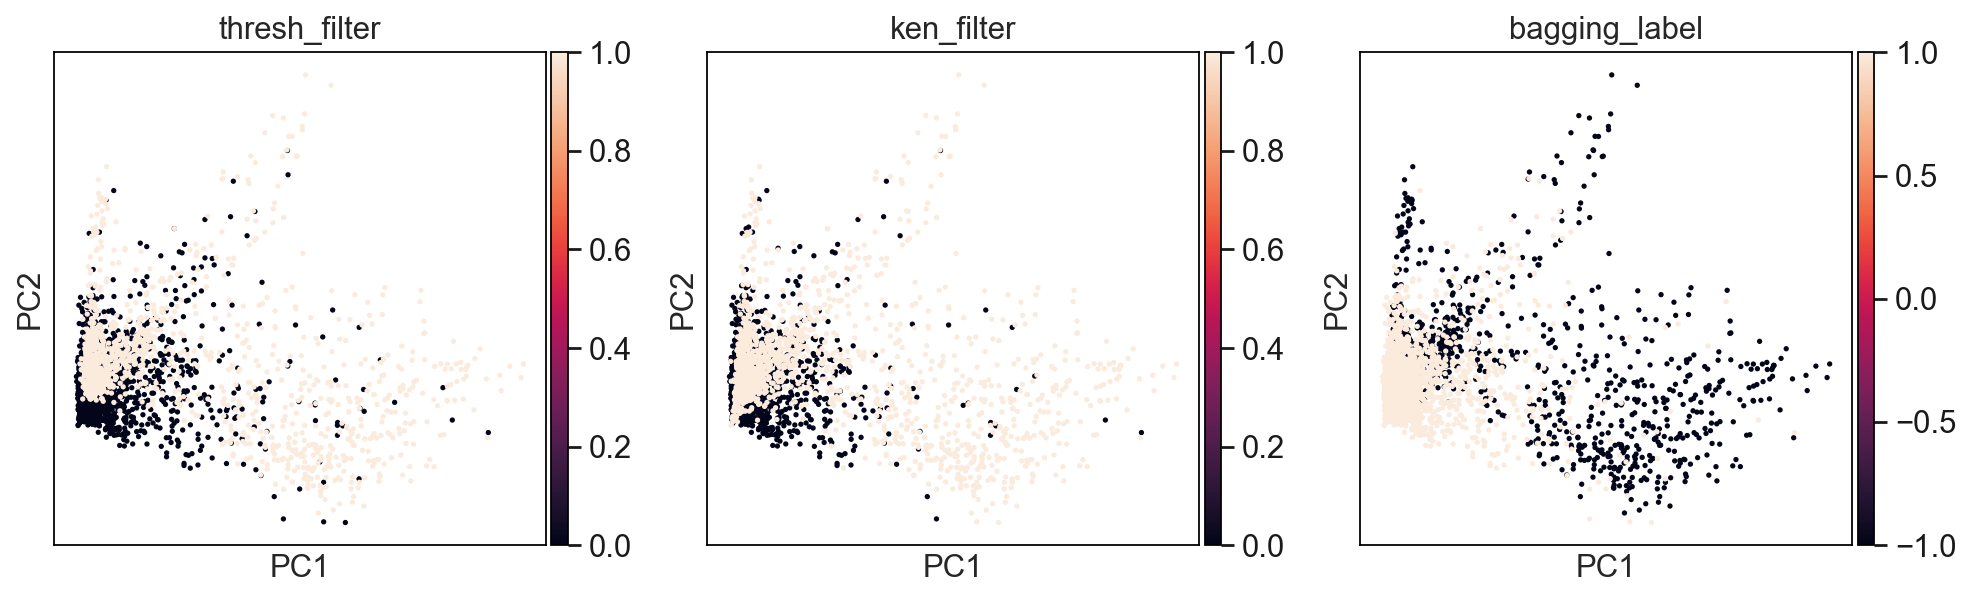

In [42]:
# compare two-step results to threshold filtering and Ken's labels
sc.pl.pca(s1, color=['thresh_filter','ken_filter','bagging_label'])

In [43]:
len(set(s1.obs_names[s1.obs['bagging_label']==-1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

97

In [44]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['bagging_label']==-1])))

462

---
#### Now, reduce dimensions and see how embeddings/cell populations change between the two filterings (Ken and TwoStep)

In [46]:
# generate obs column with ken vs twostep for visualization
s1.obs['compare'] = 'same'
s1.obs.loc[(s1.obs['ken_filter']==1) & (s1.obs['bagging_label']==1), 'compare'] = 'ken'
s1.obs.loc[(s1.obs['bagging_label']==-1) & (s1.obs['ken_filter']==0), 'compare'] = 'twostep'

In [47]:
# create two new adata objects from ken and twostep filters
s1_ken = s1[s1.obs['ken_filter']==1,:].copy()
s1_bag = s1[s1.obs['bagging_label']==-1,:].copy()

In [48]:
# preprocess ken's dataset
s1_ken.X = s1_ken.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ken, min_cells=1)
recipe_fcc(s1_ken, X_final='arcsinh_norm', mito_names='^mt-')
s1_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ken.obs['n_genes_by_counts'])

... storing 'compare' as categorical


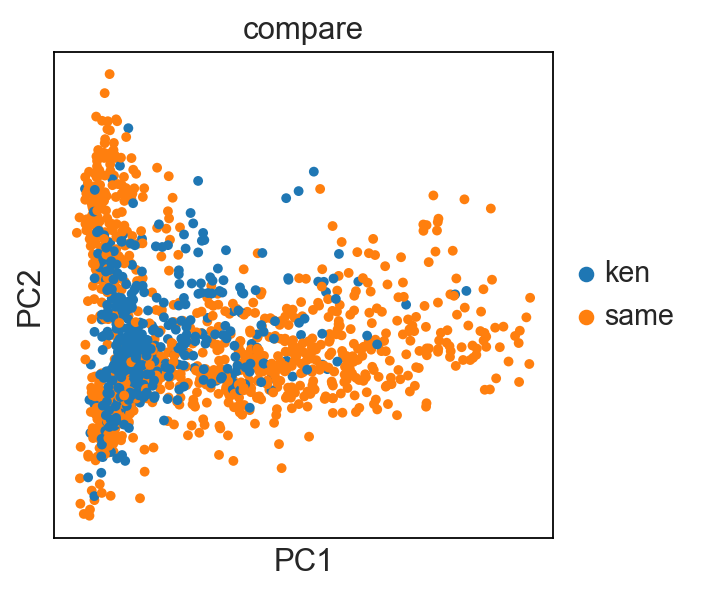

CPU times: user 1.5 s, sys: 305 ms, total: 1.8 s
Wall time: 319 ms


In [49]:
%%time
sc.tl.pca(s1_ken, n_comps=10)
sc.pl.pca(s1_ken, color=['compare'])

In [50]:
sc.pp.neighbors(s1_ken, n_neighbors=int(np.sqrt(s1_ken.n_obs)))
sc.tl.umap(s1_ken)

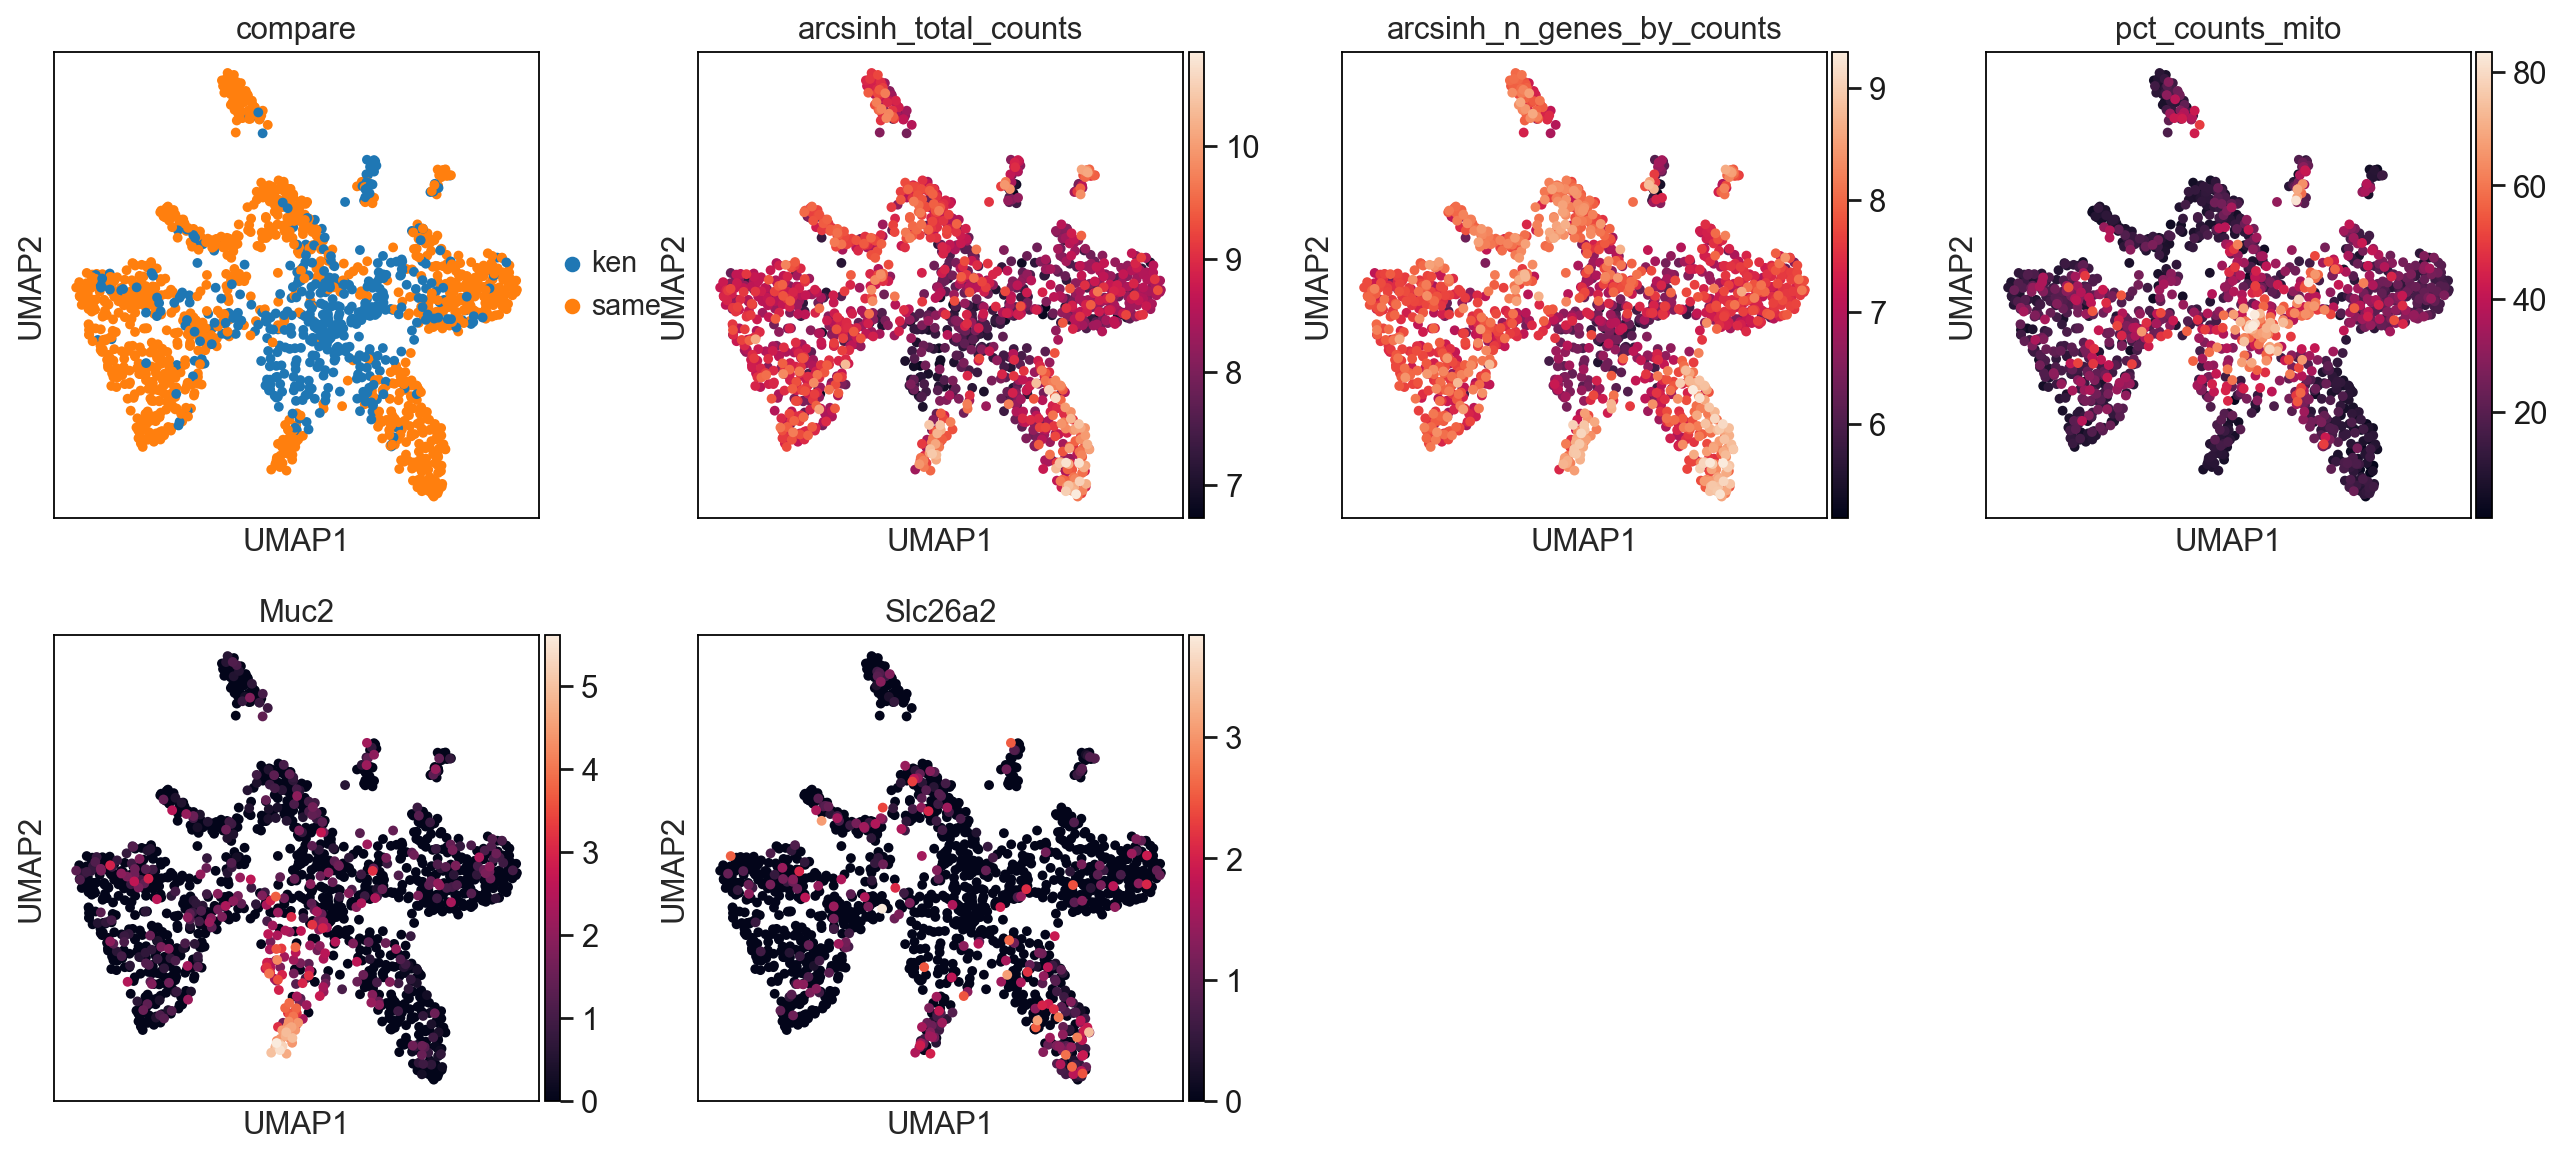

In [51]:
# show UMAP of Ken's data and look at difference from TwoStep
sc.pl.umap(s1_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Slc26a2'])

---
#### Now do the same on TwoStep results

In [52]:
# preprocess
s1_bag.X = s1_bag.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_bag, min_cells=1)
recipe_fcc(s1_bag, X_final='arcsinh_norm', mito_names='^mt-')
s1_bag.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_bag.obs['n_genes_by_counts'])

... storing 'compare' as categorical


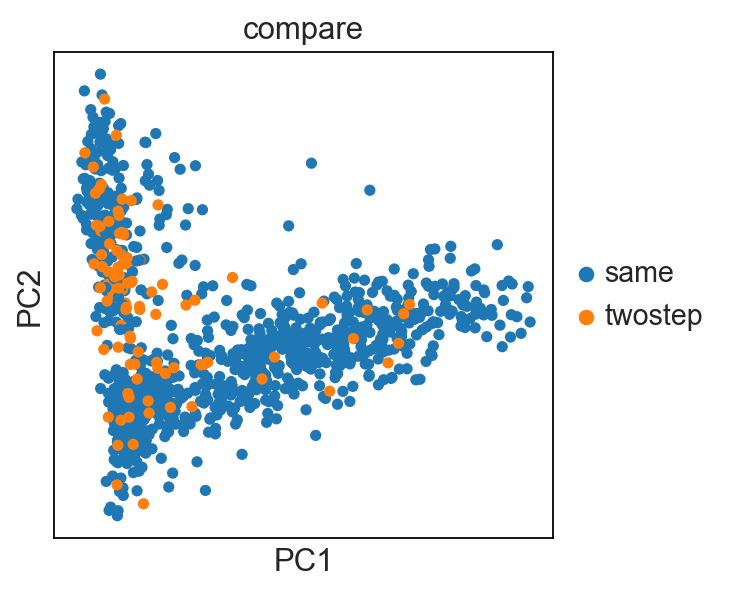

CPU times: user 1.2 s, sys: 390 ms, total: 1.59 s
Wall time: 271 ms


In [53]:
%%time
sc.tl.pca(s1_bag, n_comps=10)
sc.pl.pca(s1_bag, color=['compare'])

In [54]:
sc.pp.neighbors(s1_bag, n_neighbors=int(np.sqrt(s1_bag.n_obs)))
sc.tl.umap(s1_bag)

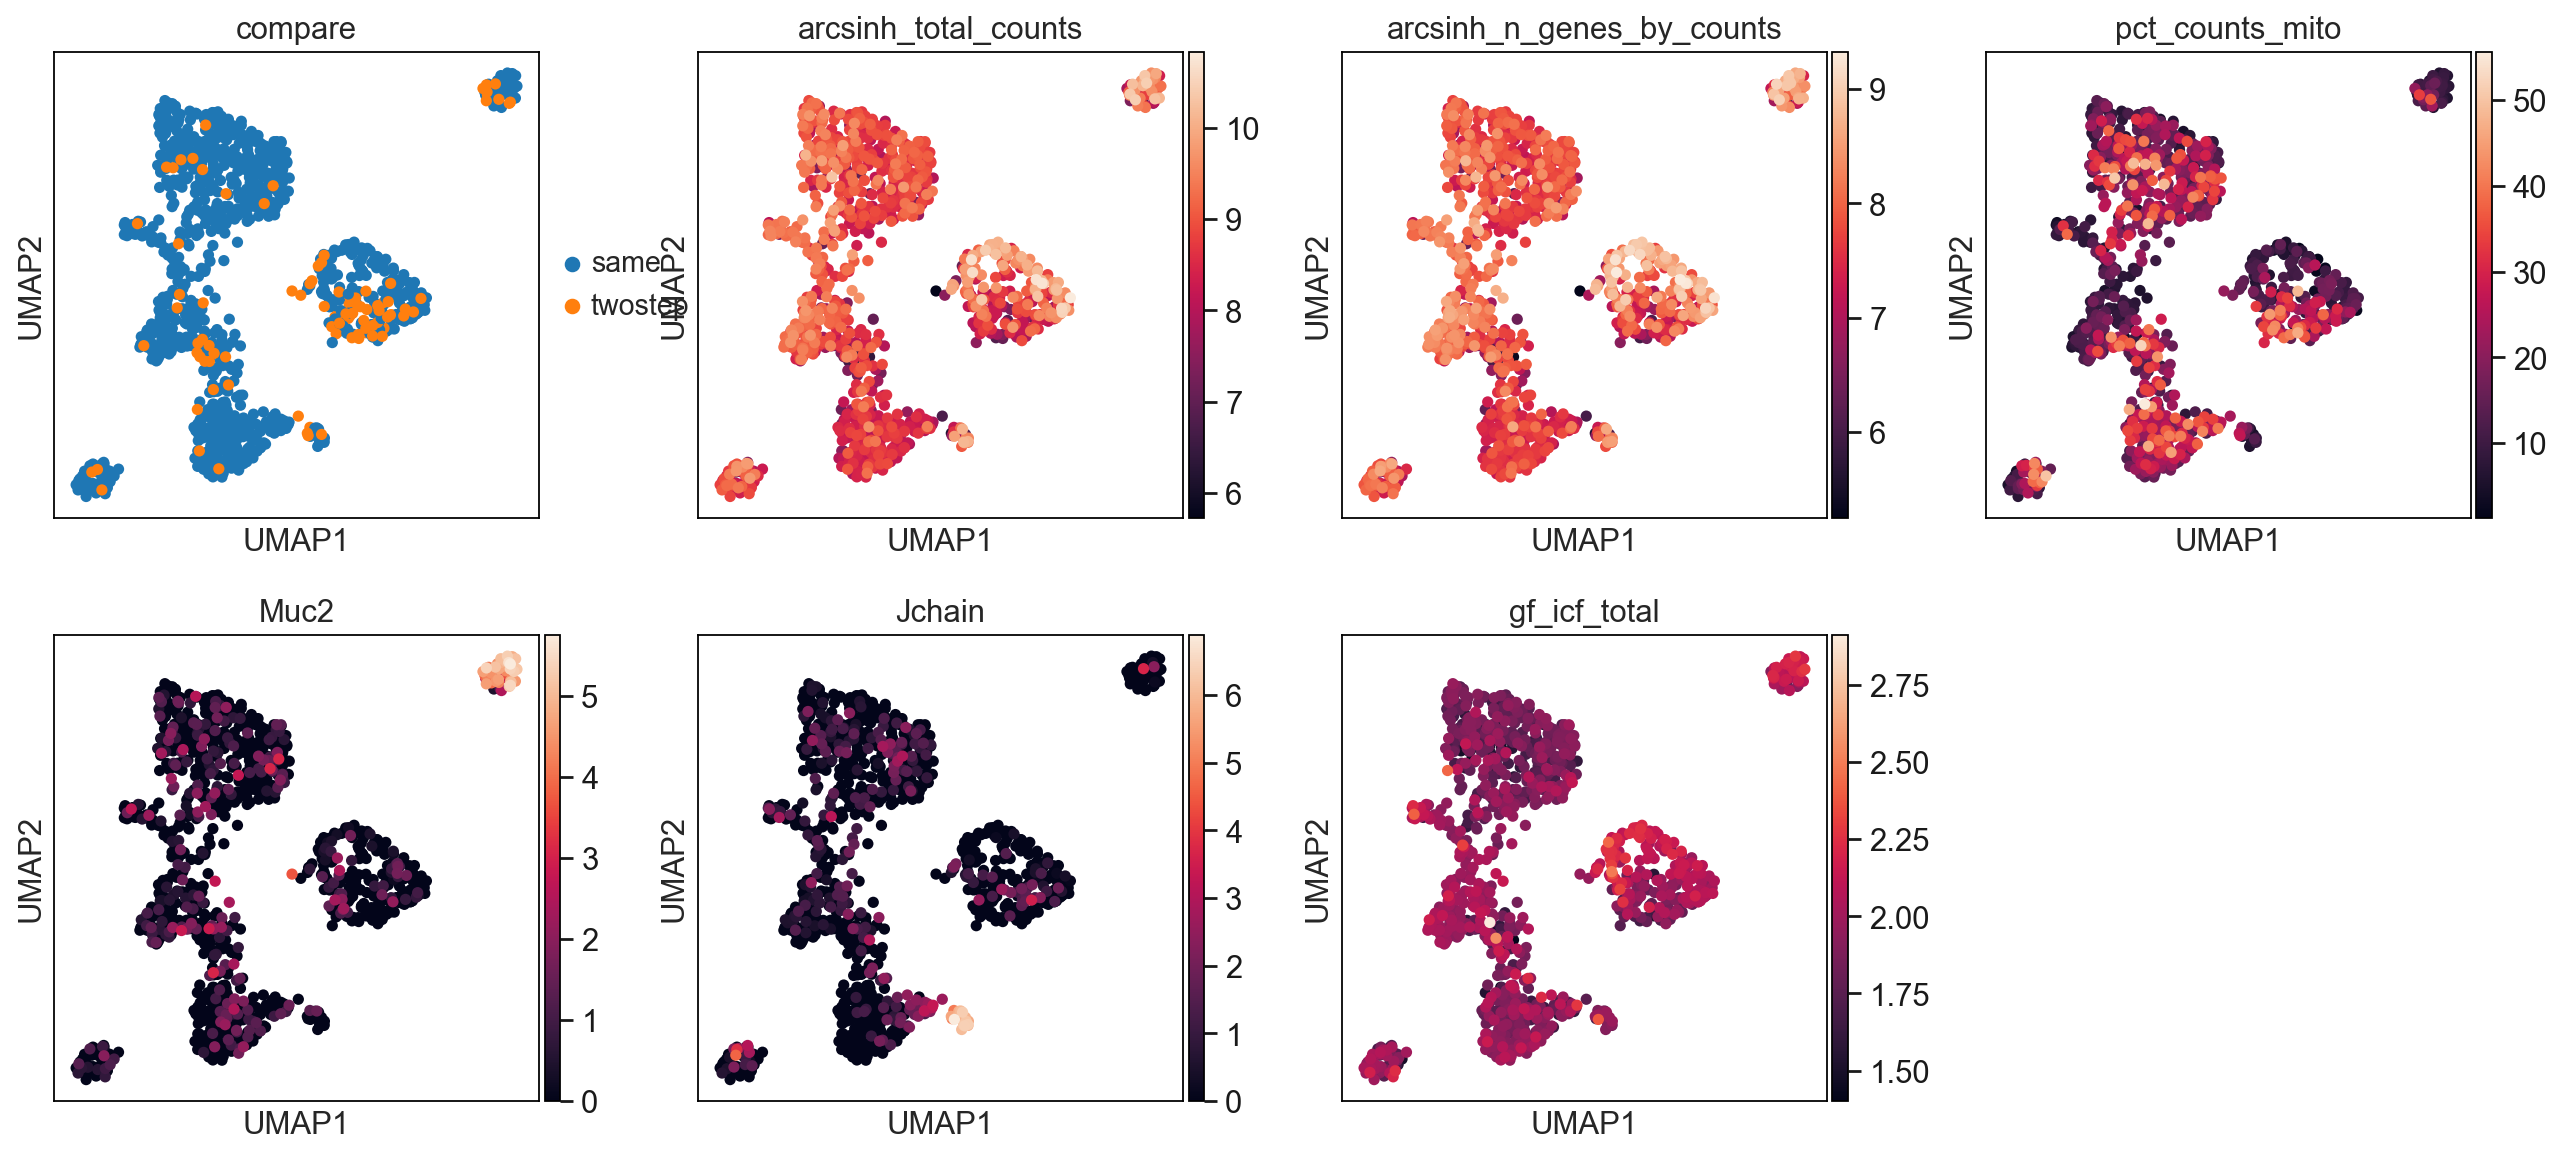

In [55]:
sc.pl.umap(s1_bag, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Jchain','gf_icf_total'])